![Logo de AA1](logo_AA1_texto_small.png) 
# Sesión 15 - Sesgo y varianza

Cuando nos enfrentamos a un conjunto de datos siempre tenemos como objetivo generar un modelo que sea capaz de clasificar correctamente todos los ejemplos que se le muestren en un futuro. Sin embargo, este es un objetivo demasiado ambicioso y es probable que nunca lleguemos a conseguirlo: nuestros modelos siempre presentarán algo de error.

Ese error que obtendremos puede ser de tres tipos:
- Error irreductible
- Error motivado por el sesgo
- Error motivado por la varianza

## 15.1 Error irreductible

El error irreductible es aquel que, como su nombre indica, no podremos reducir y puede venir motivado por muchos factores diferentes:
- falta algún atributo relevante para el problema
- hay errores en el conjunto de datos
- existen contradicciones en el conjunto (ejemplos duplicados con clase diferente)
- los ejemplos del conjunto no representan bien el problema (por ejemplo, se tomaron muestras solo en invierno y el comportamiento no es igual en verano)
- número de ejemplos insuficiente
- ...

Algunos de estos factores ya los comentamos en la práctica anterior y ya dijimos que se consideraban ruido. 

Vamos a cargar los datos que hay en el fichero **ejemplo.xlsx**:


#####################################################
#### Cargamos el conjunto de datos
#####################################################


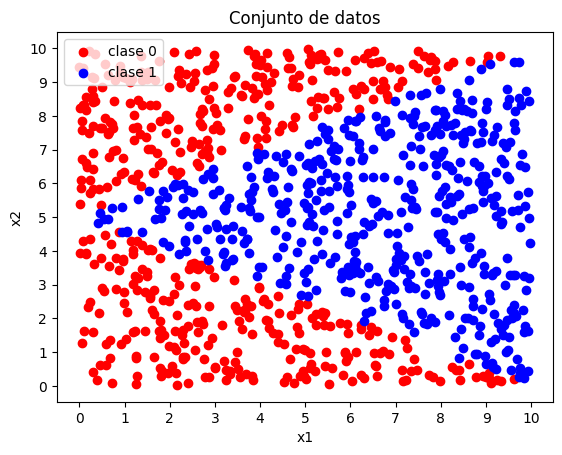

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split


def pinta(X_clase0, X_clase1, texto):
    fig, ax = plt.subplots()
    ax.scatter(X_clase0[:, 0], X_clase0[:, 1], c='r', label='clase 0')
    ax.scatter(X_clase1[:, 0], X_clase1[:, 1], c='b', label='clase 1')
    ax.set_title(texto)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.legend(loc="upper left")
    # ax.grid(True)
    ax.set_xticks(list(range(0,11)))
    ax.set_yticks(list(range(0,11)))
    plt.show()


print("\n#####################################################")
print("#### Cargamos el conjunto de datos")
print("#####################################################")

df = pd.read_excel('ejemplo.xlsx', sheet_name='datos')
filas, columnas = df.shape

# separamos las primeras columnas y las almacenamos en X
X = df.iloc[:,0:(columnas-1)]

# separamos la clase
y = df.iloc[:,(columnas-1)]

pinta(X[y==0].values, X[y==1].values, 'Conjunto de datos')

Como humanos, nada más visualizar los datos percibimos cuál es la esencia del problema y seríamos capaces de trazar dos rectas que nos permitirían generar un modelo perfecto.

Un algoritmo lo tendría un poco más complicado ya que hay zonas fronterizas con menos puntos que le harían dudar. Eso forma parte del error irreducible, que en este caso vendría motivado por la falta de ejemplos.

Es casi imposible tener un conjunto de datos que nos permita generar modelos perfectos. ¡Así que tendremos que acostumbrarnos a convivir con este error!

Los otros dos errores sí que tendremos posibilidad de reducirlos.

## 15.2 Error motivado por el sesgo

El conjunto de datos que acabamos de cargar puede ser resuelto por aquellos algoritmos que son capaces de separar el espacio en más de dos porciones pero no por aquellos que solo sean capaces de trazar una recta y separar el espacio en dos mitades (como hace la regresión logística).

Si utilizásemos una regresión logística para tratar de resolver este problema, nos encontraríamos con que su rendimiento no sería demasiado bueno (esto es algo que ya comprobamos en la práctica anterior). Estamos ante un problema estructural: queremos resolver un problema no lineal con un agoritmo lineal.

Da igual todo lo que intentemos, la regresión logística siempre presentará un rendimiento alejado del que esperaríamos en este conjunto y esto viene motivado por el sesgo que se está introduciendo al utilizar la regresión logística: *esperamos que este problema se pueda resolver de forma lineal*. Esto es lo que se conoce como **error de sesgo** (*bias* en inglés).

Cuando hacemos suposiciones sobre cómo puede ser la solución estamos introduciendo sesgo en nuestro modelo.

Los algoritmos como la regresión logística o la regresión lineal son algoritmos conocidos por tener mucho sesgo puesto que suponen que se puede encontrar una solución lineal.

Algoritmos como los K-vecinos, los árboles de decisión, las máquinas de vectores soporte o las redes neuronales son algoritmos que pueden adaptarse muy bien a los datos del conjunto sin necesidad de tener que hacer suposiciones y, por tanto, son algoritmos con poco sesgo.

Sin embargo, como ya vimos en prácticas anteriores, podemos limitar la capacidad de adaptación de estos algoritmos mediante el uso de alguno de sus hiperparámetros de tal forma que les estaríamos introduciendo un cierto sesgo.

Vamos a ver el rendimiento de un árbol de decisión en este conjunto a medida que le vamos limitando la máxima profundidad que pueden alcanzar sus ramas:

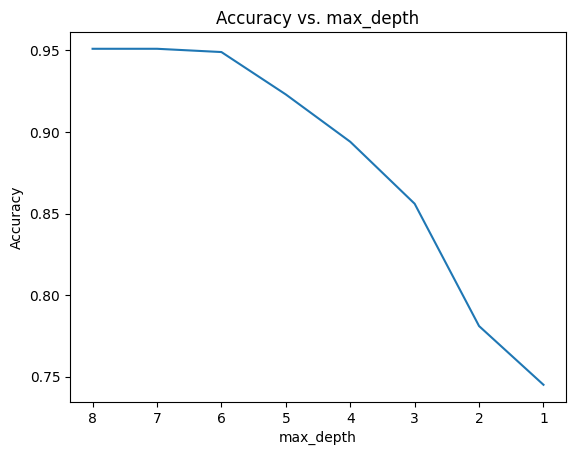

In [2]:
sys_tree = DecisionTreeClassifier(random_state=1234)

num_profundidades = 8   # vamos a probar con profundidad máxima desde 8 hasta 1
num_repeticiones = 10   # repetimos 10 veces el aprendizaje con cada profundidad

# almacenamos todos los resultados en una matriz
scores = np.zeros((num_repeticiones, num_profundidades), dtype=np.float32)

for rep in range(num_repeticiones):
    # utilizamos un 90% de ejemplos para entrenar
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rep, stratify=y)

    for p in range(1,num_profundidades+1):
        sys_tree.set_params(max_depth=p)   # cambiamos la profundidad máxima
        sys_tree.fit(X_train, y_train)     # entrenamos
        y_pred = sys_tree.predict(X_test)  # evaluamos
        scores[rep][p-1] = metrics.accuracy_score(y_test, y_pred)


depth = [str(p) for p in range(num_profundidades, 0, -1)]   # creo los ticks del eje x
medias = np.mean(scores, axis=0)   # se calculan las medias para cada profundidad

fig, ax = plt.subplots()
ax.plot(depth, medias[::-1])
ax.set_title('Accuracy vs. max_depth')
ax.set_xlabel('max_depth')
ax.set_ylabel('Accuracy')
plt.show()

Podemos ver que el árbol tiene un rendimiento similar con profundidades altas, pero cuando se va limitando su profundidad el rendimiento comienza a decrecer. El caso extremo se observa con `max_depth=1`, en el que el árbol solo puede dividir el espacio en dos mitades.

Cuando se le permiten profundidades altas vemos que está fallando un 5% de los ejemplos de test. Este error podríamos pensar que es exclusivamente error irreducible, pero no es así; parte de ese error es también error de sesgo, puesto que debemos tener en cuenta que las rectas perfectas en este caso son rectas oblicuas y el árbol de decisión que estamos utilizando solo es capaz de trazar cortes perpendiculares a los ejes, así que algo de ese error viene motivado porque estamos suponiendo que el problema se puede resolver con cortes perpendiculares.

Sobre este error sí que podemos actuar puesto que podemos utilizar un algoritmo que se adapte mejor al problema.


## 15.3 Error motivado por la varianza

El tercero de los errores es el motivado por la varianza. 

Cuando entrenamos un modelo lo estamos haciendo utilizando un conjunto de entrenamiento determinado. Una vez entrenado el modelo, lo utilizaremos para clasificar ejemplos no vistos durante el entrenamiento y obtendremos una determinada accuracy.

¿Qué sucederá si cambiamos el conjunto de entrenamiento y volvemos a entrenar? Idealmente, el modelo que se genere debería obtener una accuracy similar a la del primer modelo ante casos no vistos durante el entrenamiento, pero algunas veces esto no es así.

Si la diferencia en accuracy entre los dos modelos es muy alta diremos que hay mucha varianza en la estimación y si es baja diremos que hay poca varianza.

Utilizando el mismo conjunto de datos, vamos a utilizar únicamente el 10% de ejemplos para entrenar y vamos a ver cómo afecta a los algoritmos:

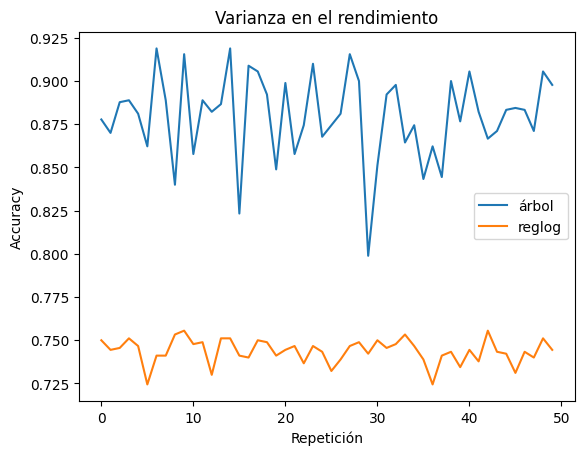

Árbol  - Accuracy: 0.8796 +- 0.0245
Reglog - Accuracy: 0.7438 +- 0.0070


In [3]:
sys_tree = DecisionTreeClassifier(random_state=1234)
sys_lr = LogisticRegression()

num_repeticiones = 50  # vamos a entrenar 50 modelos
# almacenamos los resultados en una matriz
scores = np.zeros((num_repeticiones, 2), dtype=np.float32)
for rep in range(num_repeticiones):
    # utilizamos un 10% de ejemplos para entrenar
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=rep, stratify=y)

    sys_tree.fit(X_train, y_train)  # árbol de decisión
    y_pred = sys_tree.predict(X_test)
    scores[rep][0] = metrics.accuracy_score(y_test, y_pred)

    sys_lr.fit(X_train, y_train)   # regresión logística
    y_pred = sys_lr.predict(X_test)
    scores[rep][1] = metrics.accuracy_score(y_test, y_pred)

fig, ax = plt.subplots()
ax.plot(range(num_repeticiones), scores[:,0], label='árbol')
ax.plot(range(num_repeticiones), scores[:,1], label='reglog')
ax.set_title('Varianza en el rendimiento')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Repetición')
ax.legend(loc="best")
plt.show()
print("Árbol  - Accuracy: %.4f +- %.4f" % (np.mean(scores[:,0]), np.std(scores[:,0])))
print("Reglog - Accuracy: %.4f +- %.4f" % (np.mean(scores[:,1]), np.std(scores[:,1])))

Si utilizamos únicamente el 10% de los ejemplos para entrenar, vemos que el árbol de decisión tiene mucha varianza: dada su capacidad de adaptación, se adapta demasiado al conjunto de entrenamiento y luego su rendimiento en test empeora (sobreajuste).

Esto es un problema, ya que si tenemos que entregar el modelo a un cliente, podemos decirle que **en media** el modelo tiene una accuracy de 0.8796 en casos no vistos, pero eso es la media de las 50 repeticiones. Nosotros le entregaremos uno de los modelos, pero al tener tanta varianza, puede ser que el modelo que le entreguemos tenga una accuracy de 0.91 0 de 0.84.

Sin embargo, la regresión logística tiene menos varianza en este caso, aunque su rendimiento es claramente peor.

Si aumentamos el número de ejemplos de entrenamiento, los algoritmos que estructuralmente puedan adaptarse a este problema irán reduciendo su varianza.

Sobre este error podemos actuar teniendo un conjunto de datos adecuado y utilizando un algoritmo que se adapte bien al problema. Los algoritmos que tiene mayor capacidad de adaptación a los datos tienen más facilidad para comenter error de varianza.

## 15.4 Compromiso sesgo variaza

Lo ideal sería **tener bajo sesgo y baja varianza** con buen rendimiento medio, lo que implicaría no haber tenido que hacer suposiciones y obtener siempre buen resultado, pero esto no suele ser sencillo. Como norma general, debemos tener en cuenta que:
- disminuir el sesgo => aumentar la varianza
- aumentar el sesgo => disminuir la varianza  

Los algoritmos de alto sesgo suelen tener una baja varianza. Estos algoritmos son más simples y no se pueden utilizar en todos los casos. A su favor está el hecho de que se ven menos afectados por cambios en el conjunto de entrenamiento.

Los algoritmos de bajo sesgo suelen tener una alta varianza. Estos algoritmos son más versátiles y se pueden utilizar en cualquier conjunto de datos. En su contra está el hecho de que se pueden ver muy afectados por cambios en el conjunto de datos o por el ruido.

**Un buen modelo busca equilibrio entre sesgo y varianza**



## Ejercicios

1. Carga el fichero **Phishing.csv** (es un archivo de texto). 
2. Utilizando un 90% de los ejemplos para entrenar comprueba cómo afecta `max_depth` a un árbol de decisión y la `C` a una regresión logística
3. Utilizando un 10% de los ejemplos para entrenar en 50 repeticiones comprueba la varianza de un árbol de decisión y una regresión logística con sus hiperparámetros por defecto.

Estos ejercicios no es necesario entregarlos.